## Import library

In [6]:
# !pip install awswrangler

In [7]:
import awswrangler as wr
import pandas as pd
import numpy as np
from contextlib import suppress
import matplotlib.pyplot as plt

## Load Data

In [8]:
df = wr.s3.read_csv('s3://poc-ktestate/data/raw_data/20~22_total_data.csv')
model_floor = ['1F', '2F', '3F']

## Basic PreProcessing

In [9]:
## 공조기 데이터 층수 매핑
floor_dir = {'AHU04': 'AHU_B3F',
             'AHU05': 'AHU_1F',
             'AHU06': 'AHU_2F',
             'AHU07': 'AHU_3F',
             'AHU08': 'AHU_4F',
             'AHU09': 'AHU_5F',
             'AHU13': 'AHU_9F'}
new_columns = []
for column in list(df):
    try:
        new_columns.append('_'.join([floor_dir[column.split('_')[0]],column.split('_')[1]]))
    except:
        new_columns.append(column)
df = pd.DataFrame(columns = new_columns, data = df.values)

## eda_floor 대상으로만 데이터 분류 진행
floor_info = sum([['B3F'], [f'{num}F' for num in range(1,11)]], [])
eda_floor = ['1F', '2F', '3F']
temp_col = list(df)

for floor in floor_info:
    if floor not in eda_floor:
        for col in list(df):
            if floor in col:
                temp_col.remove(col)
df = df[temp_col].copy()


In [10]:
## 데이터 형변환
for col in list(df):
    with suppress(Exception): df[col] = df[col].astype('float')
    
## 날짜 변수 추가 (년, 월)
df['시간'] = pd.to_datetime(df['시간'])
df['날짜'] = pd.to_datetime(df['시간']).dt.normalize()
df['year'] = df['시간'].dt.year.astype('int')
df['month'] = df['시간'].dt.month.astype('int')

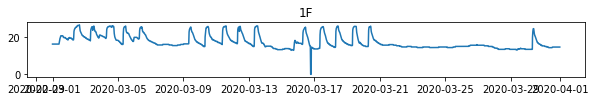

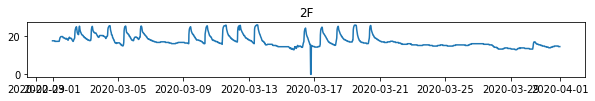

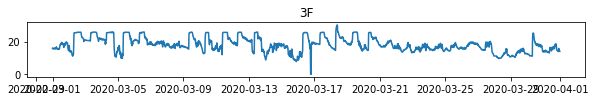

In [11]:
## 환기온도가 0인 경우는 통신이 끊겼을 때 생기는 현상으로 오류사항 (보정 필요)
temp_df = df.copy()

for floor in model_floor:
    temp_df[f'AHU_{floor}_환기온도'] = np.where((temp_df[f'AHU_{floor}_환기온도'] == 0) &
                               (abs(temp_df[f'AHU_{floor}_환기온도'] - temp_df[f'AHU_{floor}_환기온도'].shift(1)) > 3),
                               np.NaN, temp_df[f'AHU_{floor}_환기온도'])
    temp_df[f'AHU_{floor}_환기온도'] = temp_df[f'AHU_{floor}_환기온도'].interpolate(method = 'polynomial', order = 2) ## 다항식으로 NaN 보간법 진행    

    temp_df_2 = temp_df[(temp_df['year'].isin([2020])) & (temp_df['month'].isin([3]))]
    plt.figure(figsize = (10,1))
    plt.plot(temp_df_2['시간'], temp_df_2[f'AHU_{floor}_환기온도'])
    plt.title(floor)
    plt.show()    
df = temp_df.copy() ## 변경 데이터 저장

## Data Filtering

In [12]:
## 4 ~ 10월 데이터 제거
df = df[df['month'].isin([1,2,3,11,12])].copy()

## Split data as floor
for floor in model_floor:    
    globals()[f'floor_{floor}'] = []
    for column in list(df):
        if (len(column.split('_')) > 1) and (floor == column.split('_')[1]):          
            globals()[f'floor_{floor}'].append(column)
        elif (len(column.split('_')) > 2) and (floor == column.split('_')[2]):                     
            globals()[f'floor_{floor}'].append(column)
        elif (len(set(column.split('_')) & set(model_floor)) == 0):
            globals()[f'floor_{floor}'].append(column)
    ## Save each floor data
    globals()[f'df_{floor}'] = df[globals()[f'floor_{floor}']].copy()    
    
    ## AHU 가동시간이 하루에 1시간 이상인 일자 필터링
    oper_time = globals()[f'df_{floor}'].groupby('날짜')[f'AHU_{floor}_급기휀상태'].sum().reset_index()    
    oper_time = oper_time[oper_time[f'AHU_{floor}_급기휀상태'] > 60]
    globals()[f'df_{floor}'] = globals()[f'df_{floor}'][globals()[f'df_{floor}']['날짜'].isin(oper_time['날짜'])][['시간', f'AHU_{floor}_환기온도', f'AHU_{floor}_급기휀상태']]  
    globals()[f'df_{floor}'].rename(columns = {f'AHU_{floor}_환기온도' : '환기온도',
                                               f'AHU_{floor}_급기휀상태' : '급기휀상태'}, inplace = True)
    globals()[f'df_{floor}'].sort_values(['시간'], inplace = True)
    globals()[f'df_{floor}'].reset_index(drop = True, inplace = True)

## Create Train/Test Dataset

In [58]:
split_date = '2022-04-01'

train_df = pd.concat([df_1F[df_1F['시간'] < split_date], df_2F[df_2F['시간'] < split_date], df_3F[df_3F['시간'] < split_date]])
train_df.reset_index(drop = True, inplace = True)
train_df = train_df[['시간','환기온도']].copy()
train_df.to_csv('train_df.csv', index=False)

for floor in eda_floor:  
    globals()[f'test_df_{floor}'] = globals()[f'df_{floor}'][globals()[f'df_{floor}']['시간'] >= split_date].copy()
    globals()[f'test_df_{floor}'].reset_index(drop = True, inplace= True)
    globals()[f'test_df_{floor}'].to_csv(f'test_df_{floor}.csv', index = False)

In [14]:
# sliding_window
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [15]:
def daily_sliding(orig_df, LOOK_BACK, FORECAST_RANGE):
    start_idx = 0
    end_idx = LOOK_BACK
    df_x = pd.DataFrame()
    df_y = pd.DataFrame()
    while end_idx < len(orig_df):    
        temp_x = pd.DataFrame(np.reshape(orig_df[start_idx:end_idx][['환기온도']].values, (-1, LOOK_BACK)))
        temp_y = pd.DataFrame(np.reshape(orig_df[end_idx:end_idx+FORECAST_RANGE][['환기온도']].values, (-1, FORECAST_RANGE)))
        df_x = pd.concat([df_x, temp_x])
        df_y = pd.concat([df_y, temp_y])
        start_idx += 96
        end_idx += 96
    df_x.columns = [str(i) for i in list(df_x)]
    df_y.columns = [str(i) for i in list(df_y)]
    df_x.reset_index(drop = True, inplace = True)
    df_y.reset_index(drop = True, inplace = True)
    return df_x.values, df_y.values

## LSTM Model Test

In [16]:
LOOK_BACK =  672 # 1week : 672
FORECAST_RANGE = 96 # 1 day

train_x_values, train_y_values = daily_sliding(train_df, LOOK_BACK, FORECAST_RANGE)
train_x_values = np.reshape(train_x_values, (train_x_values.shape[0], train_x_values.shape[1], -1))
train_y_values = np.reshape(train_y_values, (train_y_values.shape[0], train_y_values.shape[1]))

train_x_values.shape, train_y_values.shape

((638, 672, 1), (638, 96))

In [17]:
from keras import backend as K 
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, RepeatVector, GRU, Normalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [29]:
## 일주일로 하루 평가
epochs = 500
batch_size = 4
validation = 0.1

K.clear_session()
tf.random.set_seed(1004)

model = Sequential()
model.add(LSTM(256, input_shape = train_x_values.shape[1:], return_sequences = False))
model.add(RepeatVector(FORECAST_RANGE))
model.add(Bidirectional(LSTM(32, return_sequences = True))) ## Bidirectional 추가시 성능 향상
model.add(Normalization(axis = 1))
model.add(Dense(1))

adam = Adam(learning_rate=0.0005) ## 학습 중간 과정에 변경해서 변경하는 스케줄러 있는지 확인
model.compile(optimizer=adam, loss='mse', metrics = ['mae', MeanAbsolutePercentageError()])

model.summary()

callback = EarlyStopping(monitor='loss', patience=10)
hist = model.fit(train_x_values, train_y_values, 
                 epochs = epochs, batch_size = batch_size, validation_split=validation, 
                 callbacks = [callback], shuffle = False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 96, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 96, 64)            73984     
_________________________________________________________________
normalization (Normalization (None, 96, 64)            193       
_________________________________________________________________
dense (Dense)                (None, 96, 1)             65        
Total params: 338,434
Trainable params: 338,241
Non-trainable params: 193
_________________________________________________________________
Epoch 1/500
144/144 [==============================] - 9s 38ms/step - loss: 130.8893 - mae: 10.0043 - mean_absolut

In [20]:
model.save('lstm_model_v2.h5')

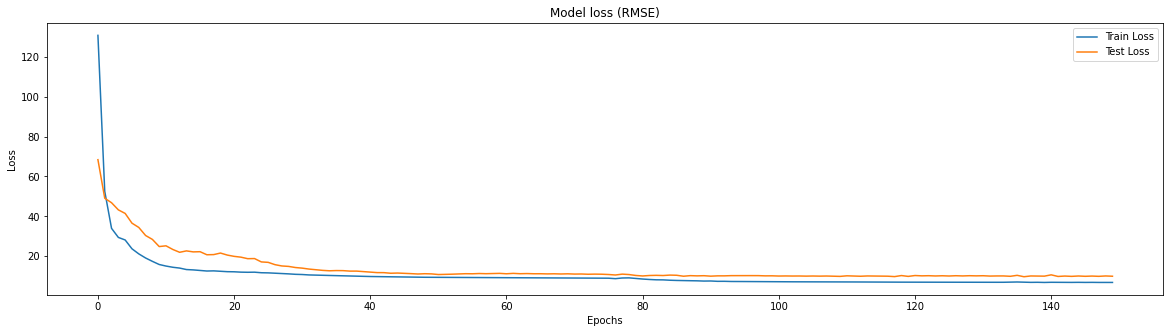

In [30]:
## 손실곡선
plt.figure(figsize=(20,5))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.title('Model loss (RMSE)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

(18, 672, 1) (18, 96, 1)
1.9183626


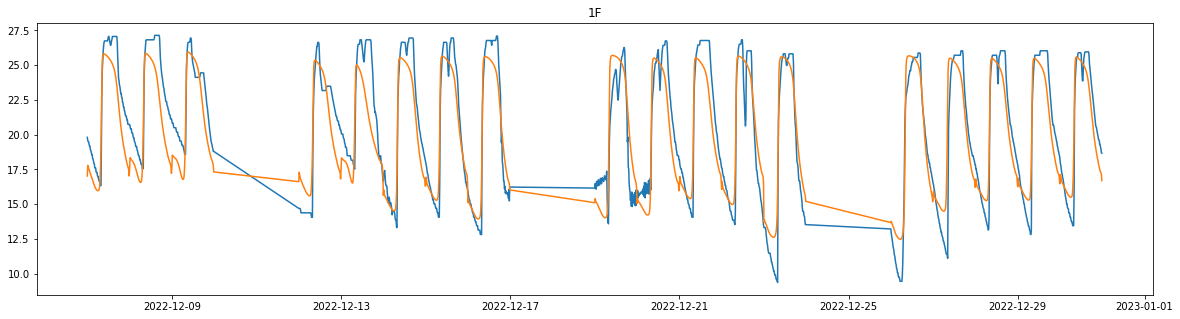

(18, 672, 1) (18, 96, 1)
2.0769885


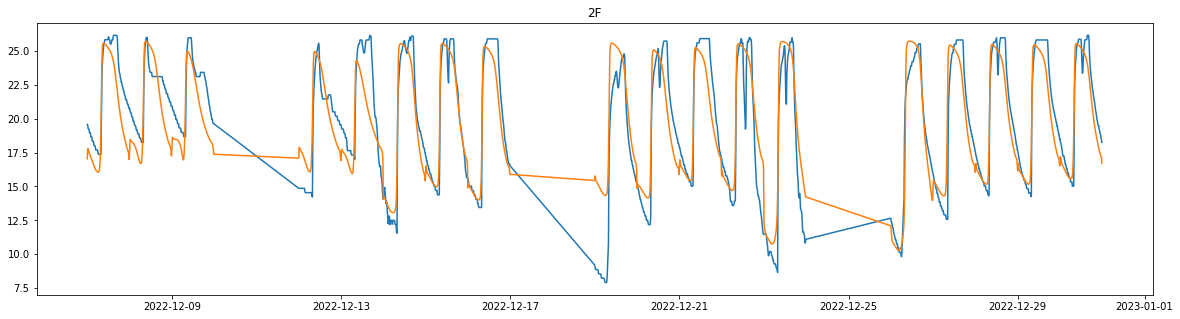

(18, 672, 1) (18, 96, 1)
3.345597


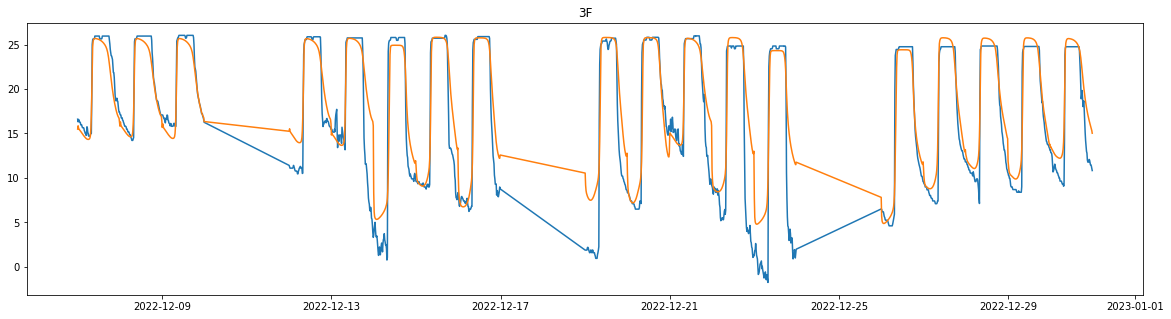

In [75]:
temp_pred = []
temp_act = []
LOOK_BACK =  672 # 1week : 672
FORECAST_RANGE = 96 # 1 day

for floor in eda_floor:
    globals()[f'test_x_{floor}'], globals()[f'test_y_{floor}'] = daily_sliding(globals()[f'test_df_{floor}'], LOOK_BACK, FORECAST_RANGE)
    test_x_values = globals()[f'test_x_{floor}']
    test_y_values = globals()[f'test_y_{floor}']
    
    globals()[f'test_df_{floor}']['날짜'] = pd.to_datetime(globals()[f'test_df_{floor}']['시간']).dt.normalize()
    globals()[f'test_date_{floor}'] = globals()[f'test_df_{floor}']['날짜'].unique()
    globals()[f'test_date_{floor}'].sort()
    globals()[f'test_x_{floor}'] = pd.DataFrame(index = globals()[f'test_date_{floor}'][7:], data = globals()[f'test_x_{floor}'])    
    

    test_x_values = np.reshape(test_x_values, (test_x_values.shape[0], test_x_values.shape[1], -1))
    test_y_values = np.reshape(test_y_values, (test_y_values.shape[0], test_y_values.shape[1], -1))
    print(test_x_values.shape, test_y_values.shape)
    pred = model.predict(test_x_values)
    
    temp_pred.append(pred)
    temp_act.append(test_y_values)

    # print(MeanSquaredError()(test_y_values, pred))
    print(np.sqrt(MeanSquaredError()(test_y_values, pred)))
    # print(MeanAbsoluteError()(test_y_values, pred))
    # print(MeanAbsolutePercentageError()(test_y_values, pred))
    plt.figure(figsize = (20,5))
    plt.plot(globals()[f'test_df_{floor}'][-len(test_y_values.flatten()):]['시간'], test_y_values.flatten())
    plt.plot(globals()[f'test_df_{floor}'][-len(pred.flatten()):]['시간'], pred.flatten())
    plt.title(floor)

    plt.show()

In [56]:
## 전체 예측값 RMSE 결과 비교
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(sum([temp[0].flatten().tolist() for temp in temp_act], []),
                          sum([temp[0].flatten().tolist() for temp in temp_pred], [])))

1.9060133544071463